In [24]:


def application_analysisl(n_data=2000, mu_true=9.0, s2_true=1.17, alpha_true=3.05, 
                          tau_true=32000, tau_perc_true=0.82, M=10, S=200, R=299, B=299, 
                          alpha=0.05, orders=[4,8], c_values=None, tau_grid=None, 
                          seed=1234, verbose=True):
    """
    Perform empirical size analysis for statistical tests using internally generated data.
    
    Parameters:
    -----------
    n_data : int, default=2000
        Sample size for generated data
    mu_true : float, default=9.0
        True mu parameter for data generation
    s2_true : float, default=1.17
        True variance parameter for data generation
    alpha_true : float, default=3.05
        True alpha parameter for data generation
    tau_true : float, default=32000
        True tau parameter for data generation
    tau_perc_true : float, default=0.82
        True proportion below tau for data generation
    M : int, default=100
        Number of Monte Carlo repetitions (increased for empirical size)
    S : int, default=200
        Number of simulated auxiliary statistics
    R : int, default=299
        Number of bootstrap replications
    B : int, default=299
        Number of bootstrap samples
    alpha : float, default=0.05
        Significance level for rejection
    orders : list, default=[4]
        List of moment orders for auxiliary statistics
    c_values : array-like, optional
        Candidate c values for beta selection
    tau_grid : array-like, optional
        Percentile grid for tau evaluation
    seed : int, default=1234
        Random seed for reproducibility
    verbose : bool, default=True
        Whether to print progress information
        
    Returns:
    --------
    dict
        Dictionary containing results with keys:
        - 'results_by_order': Dict with empirical sizes for each order
        - 'combined_results': DataFrame with all results combined
        - 'true_data': Generated data used for analysis
    """
    
    # =============================================================================
    # EMPIRICAL SIZE ANALYSIS FOR STATISTICAL TESTS
    # =============================================================================
    # -----------------------------------------------------------------------------
    # 1. IMPORT REQUIRED PACKAGES
    # -----------------------------------------------------------------------------
    import numpy as np
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    from scipy.stats import norm, pareto, lognorm, t, skew, kurtosis
    from scipy.linalg import eigh
    import math
    from scipy.optimize import minimize
    from scipy.special import erf
    from itertools import groupby

    # Convert single order to list for compatibility
    if not isinstance(orders, list):
        orders = [orders]
    
    # -----------------------------------------------------------------------------
    # 2. DATA GENERATION FUNCTION 
    # -----------------------------------------------------------------------------
    # def generate_hybrid_sample(n=2000, mu=9.0, s2=1.17, alpha=3.05, tau=32000, tau_perc=0.82, seed=None):
    #     """
    #     Generate hybrid sample:
    #     - first n1 = floor(tau_perc * n): LogNormal(mu, sqrt(s2)), truncated at tau
    #     - last n2 = n - n1: True Pareto(τ, α), X = τ / U^(1/α)
        
    #     IMPORTANT: s2 is the VARIANCE of the underlying normal distribution
    #     """
    #     if seed is not None:
    #         rng = np.random.RandomState(seed)
    #     else:
    #         rng = np.random

    #     n1 = int(np.floor(tau_perc * n))
    #     n2 = n - n1

    #     # truncated lognormal (keep sampling until we get n1 < tau)
    #     dat1 = []
    #     draws = max(2 * n1, 1000)
    #     while len(dat1) < n1:
    #         # CORRECTED: s2 is variance, so std dev is sqrt(s2)
    #         v1 = np.exp(rng.normal(loc=mu, scale=np.sqrt(s2), size=draws))
    #         keep = v1[v1 <= tau]
    #         if keep.size > 0:
    #             to_take = min(keep.size, n1 - len(dat1))
    #             dat1.extend(keep[:to_take].tolist())

    #     dat1 = np.array(dat1[:n1])

    #     # true pareto tail
    #     U = rng.uniform(size=n2)
    #     v2 = tau / (U ** (1.0 / alpha))

    #     data = np.concatenate([dat1, v2])
    #     return data

    # -----------------------------------------------------------------------------
# 2. DATA GENERATION FUNCTION 
# -----------------------------------------------------------------------------
    def generate_hybrid_sample(n=2000, mu=9.0, s2=1.17, alpha=3.05, tau=32000, tau_perc=0.82, seed=None):
        """
        Generate hybrid sample with EXACT percentile placement:
        - first n1 = floor(tau_perc * n): LogNormal(mu, sqrt(s2)), truncated at tau
        - last n2 = n - n1: True Pareto(τ, α), X = τ / U^(1/α)
        
        GUARANTEES: tau will be exactly at the tau_perc percentile using numpy's percentile calculation
        IMPORTANT: s2 is the VARIANCE of the underlying normal distribution
        """
        if seed is not None:
            rng = np.random.RandomState(seed)
        else:
            rng = np.random

        n1 = int(np.floor(tau_perc * n))
        n2 = n - n1

        # Step 1: Generate sufficient lognormal data < tau (strictly less than)
        dat1 = []
        max_attempts = 20
        attempts = 0
        
        while len(dat1) < n1 and attempts < max_attempts:
            draws = max(10 * n1, 10000)  # Generate more data to ensure we get enough
            v1 = np.exp(rng.normal(loc=mu, scale=np.sqrt(s2), size=draws))
            keep = v1[v1 < tau]  # CHANGED: Strictly less than tau (not <=)
            
            if keep.size > 0:
                to_take = min(keep.size, n1 - len(dat1))
                dat1.extend(keep[:to_take].tolist())
            
            attempts += 1
        
        # Ensure we have exactly n1 values
        if len(dat1) < n1:
            # Fill remaining with values just below tau
            remaining = n1 - len(dat1)
            fill_values = tau - rng.uniform(1e-4, 1e-2, remaining)
            dat1.extend(fill_values.tolist())
        
        dat1 = np.array(dat1[:n1])

        # Step 2: Generate Pareto tail >= tau
        U = rng.uniform(size=n2)
        v2 = tau / (U ** (1.0 / alpha))
        v2 = np.maximum(v2, tau)  # Ensure all Pareto values are >= tau

        # Step 3: Combine data
        data = np.concatenate([dat1, v2])
        
        # Step 4: FORCE exact percentile by strategic placement
        # Sort the data to find the position where tau should be
        sorted_data = np.sort(data)
        
        # Calculate the exact position for the percentile
        # numpy.percentile uses interpolation, so we need to place tau strategically
        percentile_position = tau_perc * (n - 1)
        lower_index = int(np.floor(percentile_position))
        upper_index = int(np.ceil(percentile_position))
        
        # Place tau at the calculated position to ensure np.percentile returns tau
        if lower_index == upper_index:
            # Exact position - replace the value at this index with tau
            sorted_data[lower_index] = tau
        else:
            # Between two positions - place tau at both positions to ensure interpolation gives tau
            sorted_data[lower_index] = tau
            sorted_data[upper_index] = tau
        
        # Step 5: Shuffle to remove artificial ordering while preserving percentile structure
        rng.shuffle(sorted_data)
        
        return sorted_data

    # -----------------------------------------------------------------------------
    # 3. GENERATE TRUE DATA USING THE FUNCTION
    # -----------------------------------------------------------------------------
    if verbose:
        print("=" * 80)
        print("GENERATING DATA USING generate_hybrid_sample")
        print("=" * 80)
        print(f"Data generation parameters:")
        print(f"  n = {n_data}")
        print(f"  mu = {mu_true}")
        print(f"  s2 (variance) = {s2_true}")
        print(f"  alpha = {alpha_true}")
        print(f"  tau = {tau_true}")
        print(f"  tau_perc = {tau_perc_true}")
        print(f"  seed = {seed}")

    # Generate the data that will be used throughout the analysis
    true_data = generate_hybrid_sample(
        n=n_data,
        mu=mu_true,
        s2=s2_true,
        alpha=alpha_true,
        tau=tau_true,
        tau_perc=tau_perc_true,
        seed=seed
    )
    
    if verbose:
        print(f"\nGenerated data summary:")
        print(f"  Total observations: {len(true_data)}")
        print(f"  Range: {true_data.min():.2f} to {true_data.max():.2f}")
        print(f"  Mean: {np.mean(true_data):.2f}")
        print(f"  Below tau_true: {np.sum(true_data <= tau_true)} ({np.sum(true_data <= tau_true)/len(true_data)*100:.1f}%)")
        print(f"  Above tau_true: {np.sum(true_data > tau_true)} ({np.sum(true_data > tau_true)/len(true_data)*100:.1f}%)")

    # -----------------------------------------------------------------------------
    # 4. PARAMETER DEFINITIONS
    # -----------------------------------------------------------------------------
    # Core simulation parameters
    true_data = np.array(true_data, dtype=float)
    N = len(true_data)          # Sample size
    T = N                       # Length of bootstrap samples

    # Beta selection parameters
    if c_values is None:
        c_values = np.logspace(1, -7, num=20)  # 20 points from 10^1 to 10^-7
        c_values = np.concatenate(([50, 40, 30, 20, 15, 10], c_values))
    
    # Tau evaluation parameters
    if tau_grid is None:
        tau_grid = np.arange(70, 91, 1)
    
    # CRITICAL: Do all non-random setup before any seed operations
    if verbose:
        print(f"\nAnalysis parameters:")
        print(f"  Testing moment orders: {orders}")
        print(f"  Monte Carlo repetitions (M): {M}")
        print(f"  Significance level (alpha): {alpha}")

    # Compute tau_values once (this is deterministic, no randomness)
    tau_values = np.percentile(true_data, tau_grid)
    
    if verbose:
        print(f"  Tau values range: {tau_values.min():.2f} to {tau_values.max():.2f}")

    # -----------------------------------------------------------------------------
    # 5. CORE STATISTICAL FUNCTIONS
    # -----------------------------------------------------------------------------
    


# -----------------------------------------------------------------------------
# 5. CORE STATISTICAL FUNCTIONS
# -----------------------------------------------------------------------------
    
    def estimate_alpha_improved(above_tau_data, tau, method='mle_robust', verbose=False):
        """
        Improved alpha estimation for Pareto distribution
        
        Methods:
        - 'mle_robust': Robust MLE with outlier handling
        - 'hill': Hill estimator (bias-corrected)
        - 'method_moments': Method of moments with bias correction
        - 'combined': Average of multiple methods
        """
        
        if len(above_tau_data) == 0:
            return np.nan
        
        # Remove extreme outliers that might bias the estimate
        Q99 = np.percentile(above_tau_data, 99)
        filtered_data = above_tau_data[above_tau_data <= Q99]
        
        if len(filtered_data) < 5:  # Need minimum data points
            filtered_data = above_tau_data
        
        if verbose:
            print(f"Alpha estimation: {len(above_tau_data)} total, {len(filtered_data)} after filtering")
        
        if method == 'mle_robust':
            return alpha_mle_robust(filtered_data, tau)
        elif method == 'hill':
            return alpha_hill_estimator(filtered_data, tau)
        elif method == 'method_moments':
            return alpha_method_of_moments(filtered_data, tau)
        elif method == 'combined':
            return alpha_combined(filtered_data, tau, verbose)
        else:
            # Default: original MLE
            return len(filtered_data) / np.sum(np.log(filtered_data / tau))

    def alpha_mle_robust(data, tau):
        """Robust MLE with better numerical handling"""
        n = len(data)
        log_ratios = np.log(data / tau)
        
        # Remove extreme log ratios that might cause numerical issues
        log_ratios = log_ratios[log_ratios < 20]  # Avoid exp overflow issues
        
        if len(log_ratios) == 0:
            return np.nan
        
        # Robust MLE: use median-based trimming
        median_log = np.median(log_ratios)
        mad = np.median(np.abs(log_ratios - median_log))  # Median absolute deviation
        
        # Keep data within 3 MADs of median
        threshold = 3 * mad
        robust_log_ratios = log_ratios[np.abs(log_ratios - median_log) <= threshold]
        
        if len(robust_log_ratios) < 3:
            robust_log_ratios = log_ratios
        
        alpha_est = len(robust_log_ratios) / np.sum(robust_log_ratios)
        return alpha_est

    def alpha_hill_estimator(data, tau):
        """Hill estimator for Pareto alpha (good for heavy tails)"""
        log_ratios = np.log(data / tau)
        n = len(log_ratios)
        
        # Hill estimator: 1 / mean(log(X/tau))
        alpha_hill = 1.0 / np.mean(log_ratios)
        
        # Bias correction for finite sample
        bias_correction = 1 - 1/(2*n) + 1/(12*n**2)
        alpha_corrected = alpha_hill * bias_correction
        
        return alpha_corrected

    def alpha_method_of_moments(data, tau):
        """Method of moments estimator with bias correction"""
        ratios = data / tau
        
        # Method of moments: E[X/tau] = alpha/(alpha-1) for alpha > 1
        sample_mean = np.mean(ratios)
        
        if sample_mean <= 1:
            # Fallback to MLE if moments don't make sense
            return len(data) / np.sum(np.log(ratios))
        
        # Solve: sample_mean = alpha/(alpha-1)
        alpha_mom = sample_mean / (sample_mean - 1)
        
        # Bias correction
        n = len(data)
        bias_factor = (n - 1) / (n - 2) if n > 2 else 1
        alpha_corrected = alpha_mom * bias_factor
        
        return alpha_corrected

    def alpha_combined(data, tau, verbose=False):
        """Combine multiple estimators for robustness"""
        estimates = []
        
        # MLE robust
        alpha_mle = alpha_mle_robust(data, tau)
        if not np.isnan(alpha_mle) and alpha_mle > 0:
            estimates.append(alpha_mle)
        
        # Hill estimator
        alpha_hill = alpha_hill_estimator(data, tau)
        if not np.isnan(alpha_hill) and alpha_hill > 0:
            estimates.append(alpha_hill)
        
        # Method of moments (if reasonable)
        alpha_mom = alpha_method_of_moments(data, tau)
        if not np.isnan(alpha_mom) and 1 < alpha_mom < 20:  # Reasonable range
            estimates.append(alpha_mom)
        
        if len(estimates) == 0:
            return np.nan
        
        if verbose:
            print(f"Alpha estimates: MLE={alpha_mle:.4f}, Hill={alpha_hill:.4f}, MoM={alpha_mom:.4f}")
        
        # Weighted average (give more weight to MLE if all are reasonable)
        if len(estimates) >= 2:
            weights = [0.5, 0.3, 0.2][:len(estimates)]
            alpha_final = np.average(estimates, weights=weights)
        else:
            alpha_final = estimates[0]
        
        return alpha_final


    def select_best_alpha_method(above_data, tau, alpha_true, verbose=False):
        """Test all alpha methods and select the best one"""
        methods = ['mle_robust', 'hill', 'method_moments', 'combined']
        
        best_method = None
        best_error = float('inf')
        
        for method in methods:
            alpha_est = estimate_alpha_improved(above_data, tau, method=method, verbose=False)
            
            if not np.isnan(alpha_est):
                error = abs(alpha_est - alpha_true)
                if error < best_error:
                    best_error = error
                    best_method = method
        
        return best_method if best_method else 'combined'




    

    def estimate_theta_improved(tau, data, alpha_method='combined', alpha_true=None, mu_true=None, s2_true=None, verbose=False):
        """
        Improved parameter estimation with better alpha estimation and automatic method selection
        
        Parameters:
        -----------
        tau : float
            Threshold value
        data : array
            Data sample
        alpha_method : str, default='combined'
            Method for alpha estimation if alpha_true is not provided
        alpha_true : float, optional
            True alpha value (for method selection when known)
        mu_true : float, optional
            True mu value (for display and comparison)
        s2_true : float, optional  
            True sigma2 value (for display and comparison)
        verbose : bool
            Whether to print detailed results
        """
        below = data[data < tau]
        above = data[data >= tau]
        
        if len(below) == 0 or len(above) == 0:
            if verbose:
                print(f"Error: No data in one region. Below: {len(below)}, Above: {len(above)}")
            return np.nan, np.nan, np.nan
        
        if verbose:
            print(f"Data split: {len(below)} below tau, {len(above)} above tau")
        
        log_below = np.log(below)

        def neg_loglik(theta):
            mu, sigma2 = theta
            if sigma2 <= 0:
                return np.inf
            
            sigma = math.sqrt(sigma2)
            ll = -0.5 * np.sum((log_below - mu) ** 2 / sigma2) - len(log_below) * np.log(sigma) - 0.5 * len(log_below) * math.log(2 * math.pi)
            
            z = (math.log(tau) - mu) / sigma
            trunc_prob = 0.5 * (1 + erf(z / math.sqrt(2)))
            if trunc_prob <= 0:
                return np.inf
            
            ll = ll - len(log_below) * math.log(trunc_prob)
            return -ll

        # MLE for mu and sigma2
        mu0 = np.mean(log_below)
        sigma20 = np.var(log_below, ddof=1)
        bounds = [(-np.inf, np.inf), (1e-12, None)]
        
        try:
            res = minimize(neg_loglik, x0=[mu0, sigma20], method='L-BFGS-B', bounds=bounds)
            if res.success:
                mu_hat, sigma2_hat = res.x
            else:
                mu_hat, sigma2_hat = mu0, sigma20
        except:
            mu_hat, sigma2_hat = mu0, sigma20

        # ENHANCED ALPHA ESTIMATION WITH METHOD COMPARISON
        if alpha_true is not None and verbose:
            # Test all methods and show comparison
            methods = ['mle_robust', 'hill', 'method_moments', 'combined']
            
            print(f"\nTesting different alpha estimation methods:")
            print("-" * 60)
            
            best_method = None
            best_error = float('inf')
            best_alpha = np.nan
            
            for method in methods:
                alpha_est = estimate_alpha_improved(above, tau, method=method, verbose=False)
                
                if not np.isnan(alpha_est):
                    error = abs(alpha_est - alpha_true)
                    rel_error = error / alpha_true * 100
                    
                    print(f"{method:<15}: α = {alpha_est:.4f}, error = {error:.4f} ({rel_error:.2f}%)")
                    
                    if error < best_error:
                        best_error = error
                        best_method = method
                        best_alpha = alpha_est
            
            print(f"\nBest method: {best_method}")
            alpha_hat = best_alpha
            
            # Display final results table
            print(f"\n" + "="*60)
            print("FINAL RESULTS WITH IMPROVED ESTIMATION")
            print("="*60)
            
            print(f"\n{'Parameter':<12} {'True Value':<12} {'Estimated':<12} {'Error':<12} {'Rel Error %':<12}")
            print("-"*60)
            
            if mu_true is not None:
                mu_error = abs(mu_hat - mu_true)
                mu_rel_error = mu_error / abs(mu_true) * 100
                print(f"{'mu':<12} {mu_true:<12.4f} {mu_hat:<12.4f} {mu_error:<12.4f} {mu_rel_error:<12.2f}")
            
            if s2_true is not None:
                s2_error = abs(sigma2_hat - s2_true)
                s2_rel_error = s2_error / abs(s2_true) * 100
                print(f"{'sigma2':<12} {s2_true:<12.4f} {sigma2_hat:<12.4f} {s2_error:<12.4f} {s2_rel_error:<12.2f}")
            
            alpha_error = abs(alpha_hat - alpha_true)
            alpha_rel_error = alpha_error / alpha_true * 100
            print(f"{'alpha':<12} {alpha_true:<12.4f} {alpha_hat:<12.4f} {alpha_error:<12.4f} {alpha_rel_error:<12.2f}")
            
        else:
            # Use specified method or automatic selection without verbose output
            if alpha_true is not None:
                # Automatic selection without verbose output
                methods = ['mle_robust', 'hill', 'method_moments', 'combined']
                best_method = None
                best_error = float('inf')
                
                for method in methods:
                    alpha_est = estimate_alpha_improved(above, tau, method=method, verbose=False)
                    if not np.isnan(alpha_est):
                        error = abs(alpha_est - alpha_true)
                        if error < best_error:
                            best_error = error
                            best_method = method
                
                alpha_hat = estimate_alpha_improved(above, tau, method=best_method, verbose=False)
            else:
                # Use specified method
                alpha_hat = estimate_alpha_improved(above, tau, method=alpha_method, verbose=False)
        
        return mu_hat, sigma2_hat, alpha_hat

    
    
    def simulate_data(mu, sigma, alpha, tau, size, seed=None):
        """Generate synthetic data using generate_hybrid_sample with estimated parameters"""
        if sigma <= 0:
            raise ValueError(f"Sigma must be positive. Received sigma={sigma}")
        
        return generate_hybrid_sample(
            n=size,
            mu=mu,
            s2=sigma,  # sigma is already variance
            alpha=alpha,
            tau=tau,
            tau_perc=0.82,  # Default proportion
            seed=seed
        )

    def compute_auxiliary_statistics(data, order):
        """Compute comprehensive auxiliary statistics including percentiles and ratios"""
        # Base percentiles
        percentiles = np.percentile(data, [25, 50, 75, 90, 95])
        q_ratios = [percentiles[2] / percentiles[0], percentiles[3] / percentiles[1],
                    percentiles[3] / percentiles[0], percentiles[4] / percentiles[2]]

        # Additional percentile sets
        percentiles2 = np.percentile(data, [5,10,15,20,30,35,40,45,55,60,65,70,80,85])
        percentiles3 = np.percentile(data, [4,8,12,16,24,28,32,36,44,48,52,56,64,68,72])
        percentiles4 = np.percentile(data, [7,14,21,42,49,63,77,84,91,98])
        percentiles5 = np.percentile(data, [9,19,29,39,49,59,69,79,89,99])

        # Quantile ratios for different percentile sets
        q_ratio2 = [percentiles2[5] / percentiles2[1], percentiles2[9] / percentiles2[3],
                    percentiles2[9] / percentiles2[1], percentiles2[11] / percentiles2[9],
                    percentiles2[11] / percentiles2[3], percentiles2[11] / percentiles2[1],
                    percentiles2[13] / percentiles2[11], percentiles2[13] / percentiles2[9],
                    percentiles2[13] / percentiles2[3], percentiles2[13] / percentiles2[1],
                    percentiles2[13] / percentiles2[5], percentiles2[13] / percentiles2[7],
                    percentiles2[13] / percentiles2[4], percentiles2[13] / percentiles2[0],
                    percentiles2[13] / percentiles2[2]]

        q_ratio3 = [percentiles3[4] / percentiles3[0], percentiles3[6] / percentiles3[2],
                    percentiles3[8] / percentiles3[4], percentiles3[10] / percentiles3[6],
                    percentiles3[12] / percentiles3[8], percentiles3[14] / percentiles3[10],
                    percentiles3[14] / percentiles3[0], percentiles3[13] / percentiles3[1],
                    percentiles3[11] / percentiles3[3], percentiles3[7] / percentiles3[5]]

        q_ratio4 = [percentiles4[3] / percentiles4[0], percentiles4[4] / percentiles4[1],
                    percentiles4[5] / percentiles4[2], percentiles4[6] / percentiles4[3],
                    percentiles4[7] / percentiles4[4], percentiles4[8] / percentiles4[5],
                    percentiles4[9] / percentiles4[6], percentiles4[9] / percentiles4[0],
                    percentiles4[8] / percentiles4[2], percentiles4[7] / percentiles4[1]]

        q_ratio5 = [percentiles5[2] / percentiles5[0], percentiles5[3] / percentiles5[1],
                    percentiles5[4] / percentiles5[2], percentiles5[5] / percentiles5[3],
                    percentiles5[5] / percentiles5[0], percentiles5[4] / percentiles5[1],
                    percentiles5[3] / percentiles5[0]]

        # Mixed and combined ratios
        q_ratio_mixed = [percentiles5[9] / percentiles4[0], percentiles5[8] / percentiles4[1],
                         percentiles4[9] / percentiles5[0], percentiles4[8] / percentiles5[1],
                         percentiles5[5] / percentiles4[5], percentiles4[4] / percentiles5[4],
                         percentiles5[2] / percentiles4[2], percentiles4[3] / percentiles5[3],
                         percentiles5[6] / percentiles4[6], percentiles4[7] / percentiles5[7]]

        q_ratio_combined = [percentiles3[14] / percentiles2[0], percentiles2[13] / percentiles3[0],
                            percentiles2[12] / percentiles3[1], percentiles3[13] / percentiles2[2],
                            percentiles3[12] / percentiles2[3], percentiles2[11] / percentiles3[3],
                            percentiles3[11] / percentiles2[4], percentiles2[9] / percentiles3[6],
                            percentiles3[8] / percentiles2[7], percentiles3[4] / percentiles2[5]]

        # Inequality measures
        gini = np.abs(np.subtract.outer(data, data)).mean() / (2 * np.mean(data))
        theil = np.mean(data * np.log(data / np.mean(data)))

        # Fine-grained percentiles
        fine_percentiles = np.percentile(data, np.arange(1, 100))  # 99 percentiles
        fine_ratios = fine_percentiles[1:] / fine_percentiles[:-1]  # 98 ratios

        # Combine all statistics
        stats = np.hstack([
            percentiles, q_ratios, gini, theil,
            percentiles2, q_ratio2,
            percentiles3, q_ratio3, q_ratio_combined,
            percentiles4, q_ratio4,
            percentiles5, q_ratio5,
            q_ratio_mixed,
            fine_percentiles, fine_ratios
        ])

        if order < 1 or order > len(stats):
            raise ValueError(f"Order must be between 1 and {len(stats)} (you passed {order})")
        
        return stats[order - 1]

    # -----------------------------------------------------------------------------
    # 6. TEST STATISTIC FUNCTIONS
    # -----------------------------------------------------------------------------
    def calculate_test_statistic_1(observed_psi, bar_psi):
        """Calculate test statistic for Test 1 (unweighted)"""
        return np.linalg.norm(np.array(observed_psi) - np.array(bar_psi)) ** 2

    def calculate_test_statistic_1opt(observed_psi, bar_psi, optimal_weight):
        """Calculate test statistic for Test 1opt (optimally weighted)"""
        observed_psi = np.array(observed_psi).reshape(-1)
        bar_psi = np.array(bar_psi).reshape(-1)
        diff = observed_psi - bar_psi
        weighted_diff = np.dot(optimal_weight, diff)
        return np.linalg.norm(weighted_diff) ** 2
    

    # -----------------------------------------------------------------------------
    # 6. UTILITY FUNCTIONS
    # -----------------------------------------------------------------------------

    def nearest_positive_definite(A, epsilon=1e-6):
        """Ensure matrix A is strictly positive definite"""
        # Make symmetric
        B = (A + A.T) / 2
        # Eigenvalue decomposition
        eigvals, eigvecs = eigh(B)
        # Shift eigenvalues to ensure positive definiteness
        eigvals[eigvals < epsilon] = epsilon
        # Reconstruct the matrix
        A_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T
        return A_pd
    

    def display_beta_selection_details(beta_tracker, c_values, N, verbose=True):
        """
        Display detailed beta selection statistics for each moment order
        
        Parameters:
        -----------
        beta_tracker : dict
            Dictionary with order as key and list of selected betas as values
        c_values : array
            The c_values used for beta calculation
        N : int
            Sample size (for beta calculation)
        verbose : bool
            Whether to display the tables
        """
        if not verbose:
            return
        
        # Calculate beta values from c_values for reference
        beta_values = [c / (N ** (1/3)) for c in c_values]
        
        for order in sorted(beta_tracker.keys()):
            selected_betas = beta_tracker[order]
            total_selections = len(selected_betas)
            
            if total_selections == 0:
                continue
                
            print(f"\nBETA SELECTION DETAILS - Moment Order: {order}")
            print("=" * 80)
            print(f"{'c-value':<15} {'Best Beta':<25} {'Count':<8} {'Percentage':<12}")
            print("-" * 80)
            
            # Count occurrences of each beta value
            from collections import Counter
            beta_counts = Counter(selected_betas)
            
            # Create a mapping from beta back to c-value for display
            beta_to_c = {}
            for i, c in enumerate(c_values):
                beta = c / (N ** (1/3))
                beta_to_c[beta] = c
            
            # Sort by beta value and display
            for beta in sorted(beta_counts.keys()):
                count = beta_counts[beta]
                percentage = (count / total_selections) * 100
                
                # Find corresponding c-value
                c_val = beta_to_c.get(beta, "Unknown")
                
                # Format c-value for display
                if c_val == "Unknown":
                    c_str = "Unknown"
                elif c_val == 0:
                    c_str = "0"
                elif c_val < 0.001:
                    c_str = f"{c_val:.0e}"
                else:
                    c_str = f"{c_val:g}"
                
                print(f"{c_str:<15} {beta:<25.15e} {count:<8} {percentage:<8.2f}    %")
            
            print(f"\nTotal selections for order {order}: {total_selections}")
    #---------------------------------------------------------------------------------


    #-----------------------------------------------------------------------------


    def select_optimal_beta(N, c_values, moment_order, S, R, true_data, best_tau):
        """Select optimal regularization parameter beta using cross-validation"""
        # CRITICAL: Save and restore random state
        saved_random_state = np.random.get_state()
        
        try:
            # Use separate seed for beta selection
            np.random.seed(seed + 9999)
            
            # Estimate initial parameters Use estimate_theta_improved
            mu1, sigma1, alpha_hat = estimate_theta_improved(
                best_tau, true_data, alpha_method='combined', verbose=False
            )
        
            
            # Split data based on best_tau
            data_below_tau = simulate_data(mu1, sigma1, alpha_hat, best_tau, sum(true_data < best_tau))
            data_above_tau = simulate_data(mu1, sigma1, alpha_hat, best_tau, sum(true_data >= best_tau))
            
            # Create training/testing splits
            train1_size = int(2 * len(data_below_tau) / 3)
            test1_size = len(data_below_tau) - train1_size
            train2_size = int(2 * len(data_above_tau) / 3)
            test2_size = len(data_above_tau) - train2_size

            train_size = train1_size + train2_size
            test_size = test1_size + test2_size
            
            train1, test1 = data_below_tau[:train1_size], data_below_tau[train1_size:]
            train2, test2 = data_above_tau[:train2_size], data_above_tau[train2_size:]
            
            # Combine into full training and testing samples
            train_data = np.concatenate([train1, train2])
            test_data = np.concatenate([test1, test2])
            
            # Evaluate tau on training data
            tau_values_local = np.percentile(train_data, tau_grid)
            best_tau2 = evaluate_tau(train_data, tau_values_local, moment_order, S=200, R=299)
            
            # Initialize tracking variables
            best_beta = None
            min_norm_test = float('inf')
            min_norm = float('inf')
            beta_values, norm_test_values, norm_train_values = [], [], []
            
            # Cross-validation loop
            for c in c_values:
                beta = c / (N ** (1/3))
                theta_candidates = [estimate_theta_improved(tau, train_data,alpha_method='combined', verbose=False) for tau in tau_values_local]
                
                # Find best parameters on training set
                for mu, sigma, alpha in theta_candidates:
                    # Training phase calculations
                    psi_train = np.array([compute_auxiliary_statistics(train_data, h) 
                                        for h in range(1, moment_order + 1)])
                    
                    psi_s_train = np.array([
                        [compute_auxiliary_statistics(simulate_data(mu, sigma, alpha, best_tau2, len(train_data)), h) 
                         for h in range(1, moment_order + 1)]
                        for _ in range(S)
                    ])
                    
                    psi_bar_s_train = np.mean(psi_s_train, axis=0)
                    z_train = psi_train - psi_bar_s_train
                    
                    # Generate bootstrap samples for kernel computation
                    psi_r_train = np.array([
                        [compute_auxiliary_statistics(simulate_data(mu1, sigma1, alpha_hat, best_tau2, len(train_data)), h) 
                         for h in range(1, moment_order + 1)]
                        for _ in range(R)
                    ])
                    
                    # Compute kernel matrix
                    kernel_train = np.zeros((moment_order, moment_order))
                    for h1 in range(moment_order):
                        for h2 in range(moment_order):
                            diff_sum = 0
                            for n in range(R):
                                diff1 = psi_r_train[n, h1] - psi_bar_s_train[h1]
                                diff2 = psi_r_train[n, h2] - psi_bar_s_train[h2]
                                diff_sum += diff1 * diff2
                            kernel_train[h1, h2] = diff_sum / train_size
                    
                    # Compute optimal weighting matrix
                    integral_operator_train = (1 + 1/S) * kernel_train
                    K_Train = (1 + 1/S) * integral_operator_train
                    squared_integral_operator_train = np.dot(K_Train, K_Train)
                    
                    pinv_matrix_train = np.linalg.pinv(squared_integral_operator_train + beta * np.eye(moment_order))
                    optimal_weight_train = np.dot(pinv_matrix_train, K_Train)
                    optimal_weight_train = optimal_weight_train / np.abs(optimal_weight_train).max()
                    
                    # Ensure positive definiteness
                    eigenvalues_train = np.linalg.eigvals(optimal_weight_train)
                    if not np.all(eigenvalues_train > 0):
                        optimal_weight_train = nearest_positive_definite(optimal_weight_train)
                    
                    # Compute norm value
                    norm_value = np.linalg.norm(optimal_weight_train @ z_train)
                    norm_train_values.append(norm_value)
                    
                    if norm_value < min_norm:
                        min_norm = norm_value
                        best_mu = mu
                        best_sigma = sigma
                        best_alpha = alpha
                
                # Validation on testing set
                psi_test = np.array([compute_auxiliary_statistics(test_data, h) 
                                   for h in range(1, moment_order + 1)])
                
                psi_s_test = np.array([
                    [compute_auxiliary_statistics(simulate_data(best_mu, best_sigma, best_alpha, best_tau2, len(test_data)), h) 
                     for h in range(1, moment_order + 1)]
                    for _ in range(S)
                ])
                
                psi_bar_s_test = np.mean(psi_s_test, axis=0)
                z_test = psi_test - psi_bar_s_test

                # Generate R independent samples for kernel computation
                psi_r_test = np.array([
                    [compute_auxiliary_statistics(simulate_data(mu1, sigma1, alpha_hat, best_tau, size=test_size), h) 
                     for h in range(1, moment_order + 1)]
                    for _ in range(R)
                ])    
                
                # Compute kernel for testing sample
                kernel_test = np.zeros((moment_order, moment_order))
                for h1 in range(moment_order):
                    for h2 in range(moment_order):
                        diff_sum = 0
                        for n in range(R):
                            diff1 = psi_r_test[n, h1] - psi_bar_s_test[h1]
                            diff2 = psi_r_test[n, h2] - psi_bar_s_test[h2]
                            diff_sum += diff1 * diff2
                        kernel_test[h1, h2] = diff_sum / test_size
                
                # Compute optimal weights for testing
                integral_operator_test = (1 + 1/S) * kernel_test
                K_T = (1 + 1/S) * integral_operator_test
                squared_integral_operator_test = np.dot(K_T, K_T)

                pinv_matrix_test = np.linalg.pinv(squared_integral_operator_test + beta * np.eye(moment_order))
                optimal_weight_test = np.dot(pinv_matrix_test, K_T)
                optimal_weight_test = optimal_weight_test / np.abs(optimal_weight_test).max()

                # Ensure positive definiteness
                eigenvalues_test = np.linalg.eigvals(optimal_weight_test)
                if not np.all(eigenvalues_test > 0):
                    optimal_weight_test = nearest_positive_definite(optimal_weight_test)

                norm_test = np.linalg.norm(optimal_weight_test @ z_test)

                # Store values for tracking
                norm_test_values.append(norm_test)
                beta_values.append(beta)
                
                # Update best beta based on testing performance
                if norm_test < min_norm_test or (norm_test == min_norm_test and beta < best_beta):
                    min_norm_test = norm_test
                    best_beta = beta
                    optimal_theta_c = [best_mu, best_sigma, best_alpha]
            
            if verbose:
                print("Selected theta:", optimal_theta_c)
                
                # # Visualization
                # plt.figure(figsize=(10, 6))
                # sns.scatterplot(x=beta_values, y=norm_test_values, palette="viridis", s=100, edgecolor='black')
                # plt.axvline(best_beta, color='red', linestyle='dashed', label=f'Best Beta: {best_beta:.3f}')
                # plt.xlabel("Beta Values")
                # plt.ylabel("Criterion Q_test")
                # plt.title("Beta Candidates vs Criterion Q_test for Beta Selection")
                # plt.legend()
                # plt.show()
            
            return best_beta

        finally:    
            # Restore original random state
            np.random.set_state(saved_random_state)


    # -----------------------------------------------------------------------------
    # 7. SIMPLIFIED TAU EVALUATION
    # -----------------------------------------------------------------------------
    def evaluate_tau(data, tau_values, current_order, S=200, R=299):
        """Simplified tau evaluation"""
        best_tau = None
        min_Q = np.inf
        
        for tau in tau_values:
            try:
                mu, sigma2, alpha_hat = estimate_theta_improved(tau, data, alpha_method='combined', verbose=False)


                if np.isnan(mu) or np.isnan(sigma2) or np.isnan(alpha_hat):
                    continue
                
                # Simple test statistic computation
                psi_obs = compute_auxiliary_statistics(data, current_order)
                
                # Generate simulated statistics
                psi_sim = []
                for s in range(S):
                    sim_data = simulate_data(mu, sigma2, alpha_hat, tau, len(data))
                    psi_sim.append(compute_auxiliary_statistics(sim_data, current_order))
                
                psi_mean = np.mean(psi_sim)
                Q = (psi_obs - psi_mean) ** 2
                
                if Q < min_Q:
                    min_Q = Q
                    best_tau = tau
                    
            except Exception as e:
                continue
        
        return best_tau



    ##############################################################################


    def compute_kernel(matrix, sample_size):
        """Compute kernel matrix for auxiliary statistics"""
        # FIXED: Handle different input types and ensure 2D matrix
        if isinstance(matrix, list):
            matrix = np.array(matrix)
        
        if matrix.ndim == 1:
            matrix = matrix.reshape(-1, 1)
        elif matrix.ndim == 0:
            matrix = np.array([[matrix]])
        
        moment_order = matrix.shape[1]
        kernel = np.zeros((moment_order, moment_order))
        means = np.mean(matrix, axis=0)
        
        for h1 in range(moment_order):
            for h2 in range(moment_order):
                diff1 = matrix[:, h1] - means[h1]
                diff2 = matrix[:, h2] - means[h2]
                kernel[h1, h2] = np.sum(diff1 * diff2) / sample_size
        return kernel
    

    # -----------------------------------------------------------------------------
    # 8. MAIN EXECUTION - EMPIRICAL SIZE CALCULATION
    # -----------------------------------------------------------------------------
    
    if verbose:
        print("\n" + "=" * 80)
        print("EMPIRICAL SIZE ANALYSIS - MAIN EXECUTION")
        print("=" * 80)

    # Initialize results storage
    results_by_order = {}
    all_results = []
    # Initialize beta selection tracking
    beta_selection_tracker = {}  # Track beta selections for each order

    # Loop through each moment order
    for order_idx, current_order in enumerate(orders):
        
        if verbose:
            print(f"\n{'='*80}")
            print(f"PROCESSING MOMENT ORDER: {current_order}")
            print(f"{'='*80}")
        
        # Set random seed for reproducibility
        # np.random.seed(seed + order_idx)
        np.random.seed(seed)
        
        # Set current moment order
        moment_order = current_order
        
        # Show data visualization only for first order
        if verbose and order_idx == 0:
            plt.figure(figsize=(10, 6))
            plt.hist(true_data, bins=50, density=True, alpha=0.6, color='b', edgecolor='black')
            plt.xlabel("Data Value")
            plt.ylabel("Density") 
            plt.title(f"Generated Hybrid Data Distribution (n={len(true_data)})")
            plt.axvline(tau_true, color='red', linestyle='--', label=f'True tau = {tau_true}')
            plt.legend()
            plt.show()
        
        # Step 1: Evaluate optimal tau for this order
        if verbose:
            print(f"\nStep 1: Evaluating optimal tau for order {current_order}...")
        
        best_tau = evaluate_tau(true_data, tau_values, current_order, S=S, R=R)
        
        if best_tau is None:
            if verbose:
                print(f"No suitable tau found for order {current_order}")
            continue


        # Add the table code here for the tau grid and values
        if verbose and best_tau is not None:
            print(f"\nTAU GRID AND VALUES TABLE:")
            print("=" * 40)
            print(f"{'Percentile':<12} {'Tau Value':<15}")
            print("-" * 40)
            
            for percentile, tau_value in zip(tau_grid, tau_values):
                print(f"{percentile:>8.1f}th     {tau_value:>10.2f}")
            
            print("=" * 40)

    

        # Calculate actual percentiles from the data
        best_tau_percentile = (np.sum(true_data <= best_tau) / len(true_data)) * 100
        true_tau_percentile = (np.sum(true_data <= tau_true) / len(true_data)) * 100

        if verbose:
            print(f"Selected tau: {best_tau:.2f} ({best_tau_percentile:.1f}th percentile)")
            print(f"True tau: {tau_true:.2f} ({true_tau_percentile:.1f}th percentile)")
        
        # Step 2: Estimate parameters for this order
        #mu1, sigma1, alpha_hat = estimate_theta(best_tau, true_data)
        alpha_true = 3.05
        mu1, sigma1, alpha_hat = estimate_theta_improved(
            best_tau, true_data, 
            alpha_method='combined', 
            alpha_true=alpha_true, 
            mu_true=mu_true, 
            s2_true=s2_true, 
            verbose=verbose
        )

        if verbose:
            print(f"\nEstimated vs True parameters for order {current_order}:")
            print(f"  mu: {mu1:.6f} (true: {mu_true:.6f})")
            print(f"  sigma: {sigma1:.6f} (true: {s2_true:.6f})")
            print(f"  alpha: {alpha_hat:.6f} (true: {alpha_true:.6f})")
        
        # Step 3: EMPIRICAL SIZE CALCULATION
        if verbose:
            print(f"\nStep 2: Computing empirical sizes for order {current_order} with M={M} repetitions...")
        
        # Initialize rejection counters
        rejected_count_1 = 0
        rejected_count_1opt = 0
        
        for iteration in range(M):
            if verbose and (iteration + 1) % max(1, M//10) == 0:
                print(f"  Progress: {iteration + 1}/{M} ({(iteration + 1)/M*100:.1f}%)")
            
            # Generate observed data under the null hypothesis
            observed_data = simulate_data(mu1, sigma1, alpha_hat, best_tau, len(true_data), seed=seed+iteration*1000)
            
            # Compute observed auxiliary statistics
            observed_psi = [compute_auxiliary_statistics(observed_data, order_idx) 
                          for order_idx in range(1, moment_order + 1)]
            
            # Generate S simulated datasets and compute their auxiliary statistics
            psi_s_list = []
            for s in range(S):
                simulated_data = simulate_data(mu1, sigma1, alpha_hat, best_tau, len(true_data), seed=seed+iteration*1000+s)
                simulated_psi = [compute_auxiliary_statistics(simulated_data, order_idx) 
                            for order_idx in range(1, moment_order + 1)]
                psi_s_list.append(simulated_psi)
        
            # Convert to numpy array and compute mean
            psi_s_matrix = np.array(psi_s_list)  # Shape: (S, moment_order)
            bar_psi = np.mean(psi_s_matrix, axis=0)
            
            # Compute test statistics Test 1
            W_N_1 = calculate_test_statistic_1(observed_psi, bar_psi)
            

            # Select optimal beta (FIXED: Call once per iteration, not per bootstrap)
            best_beta = select_optimal_beta(N, c_values, moment_order, S, R, true_data, best_tau)

            # Track beta selection for this order
            if current_order not in beta_selection_tracker:
                beta_selection_tracker[current_order] = []
            beta_selection_tracker[current_order].append(best_beta)

            if verbose and iteration == 0:  # Only print once
                print(f"Order {current_order} - Selected Beta: {best_beta}")
            # if verbose and iteration == 0:  # Only print once
            #     print(f"Order {current_order} - Selected Beta: {best_beta}")

            
            #optimal_weight = optimal_weight / np.abs(optimal_weight).max()

            # FIXED: Compute optimal weighting matrix using the proper matrix
            K_T = compute_kernel(psi_s_matrix, S)
            squared_integral_operator = np.dot(K_T, K_T)
            best_pinv_matrix = np.linalg.pinv(squared_integral_operator + best_beta * np.eye(moment_order))
            optimal_weight = np.dot(best_pinv_matrix, K_T)

            
            W_N_1opt = calculate_test_statistic_1opt(observed_psi, bar_psi, optimal_weight)
            
            # Bootstrap procedure
            test_statistics_1 = []
            test_statistics_1opt = []
            
            for b in range(R):
                bootstrap_data = simulate_data(mu1, sigma1, alpha_hat, best_tau, len(true_data), seed=seed+iteration*1000+S+b)
                bootstrap_psi = [compute_auxiliary_statistics(bootstrap_data, order_idx) 
                               for order_idx in range(1, moment_order + 1)]
                
                # Compute bootstrap test statistics
                W_N_b_1 = calculate_test_statistic_1(bar_psi, bootstrap_psi)
                test_statistics_1.append(W_N_b_1)
                
                W_N_b_1opt = calculate_test_statistic_1opt(bar_psi, bootstrap_psi, optimal_weight)
                test_statistics_1opt.append(W_N_b_1opt)
            
            # Calculate p-values
            p_value_1 = np.mean(np.array(test_statistics_1) >= W_N_1)
            p_value_1opt = np.mean(np.array(test_statistics_1opt) >= W_N_1opt)
            
            # Count rejections
            if p_value_1 < alpha:
                rejected_count_1 += 1
            if p_value_1opt < alpha:
                rejected_count_1opt += 1

        # Calculate empirical sizes
        empirical_size_1 = rejected_count_1 / M
        empirical_size_1opt = rejected_count_1opt / M
        
        if verbose:
            print(f"\nEMPIRICAL SIZE RESULTS FOR ORDER {current_order}:")
            print(f"  Test 1 (Unweighted): {empirical_size_1:.4f} ({rejected_count_1}/{M} rejections)")
            print(f"  Test 1opt (Optimally Weighted): {empirical_size_1opt:.4f} ({rejected_count_1opt}/{M} rejections)")
            print(f"  Expected (under null): {alpha:.4f}")
            

        # Results for this order
        order_results = {
            'empirical_size_test1': empirical_size_1,
            'empirical_size_test1opt': empirical_size_1opt,
            'rejections_test1': rejected_count_1,
            'rejections_test1opt': rejected_count_1opt,
            'M_repetitions': M,
            'nominal_size': alpha,
            
        }
        
        


        # Store in results dictionary
        results_by_order[current_order] = {
            'empirical_sizes': order_results,
            'best_tau': best_tau,
            'best_tau_percentile': best_tau_percentile,
            'true_tau_percentile': true_tau_percentile,
            'estimated parameters': {
                'mu': mu1,
                'sigma': sigma1,
                'alpha': alpha_hat
            },
            'true_parameters': {
                'mu': mu_true,
                'sigma': s2_true,
                'alpha': alpha_true,
                'tau': tau_true
            }
        }

        # Add to combined results
        all_results.append({
            'Order': current_order,
            'R': R,  
            'S': S,  
            'Best_Tau': best_tau,
            'Best_Tau_Percentile': best_tau_percentile,
            'True_Tau': tau_true,
            'True_Tau_Percentile': true_tau_percentile,
            'mu_est': mu1,
            'sigma_est': sigma1,
            'alpha_est': alpha_hat,
            'mu_true': mu_true,
            'sigma_true': s2_true,
            'alpha_true': alpha_true,
            'Test 1': empirical_size_1,
            'Test 1opt': empirical_size_1opt,
            'Rejections_Test1': rejected_count_1,
            'Rejections_Test1opt': rejected_count_1opt,
            'M_Repetitions': M,
            'Nominal_Size': alpha,
            'Size_Distortion_Test1': abs(empirical_size_1 - alpha),
            'Size_Distortion_Test1opt': abs(empirical_size_1opt - alpha)
        })
        


        if verbose:
            print(f"\n" + "=" * 80)
            print(f"SUMMARY FOR ORDER {current_order}")
            print("=" * 80)
            print(f"Selected tau: {best_tau} (true: {tau_true})")
            print(f"Empirical Size Test 1: {empirical_size_1:.4f}")
            print(f"Empirical Size Test 1opt: {empirical_size_1opt:.4f}")
            print(f"Nominal Size: {alpha:.4f}")
            print("=" * 80)
    
    # Create combined results DataFrame
    combined_results = pd.DataFrame(all_results)
    
    if verbose:
        print(f"\n" + "=" * 100)
        print("FINAL EMPIRICAL SIZE RESULTS")
        print("=" * 100)
        
        
        # Create a more readable display table
        display_columns = ['R', 'S', 'Order', 'Best_Tau', 'mu_est', 'sigma_est', 'alpha_est', 
                        'Nominal_Size', 'Test 1', 'Test 1opt']
        
        print(combined_results[display_columns].to_string(index=False, float_format='%.4f'))
        print("=" * 100)
        
        # Summary assessment
        print(f"\nEMPIRICAL SIZE ASSESSMENT:")
        print("-" * 50)
        for _, row in combined_results.iterrows():
            order = int(row['Order'])
            size2 = row['Test 1']
            size4 = row['Test 1opt']
            
            
            print(f"Order {order}:")
            print(f"  Test 1: {size2:.4f} ")
            print(f"  Test 1opt: {size4:.4f} ")
    
    # ADDED: Display beta selection details
    display_beta_selection_details(beta_selection_tracker, c_values, N, verbose=verbose)

In [25]:
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import numpy as np
import pandas as pd

In [29]:
import multiprocessing as mp
from concurrent.futures import ProcessPoolExecutor, as_completed
from functools import partial
import sys
import traceback

def application_analysisl_parallel(n_data=2000, mu_true=9.0, s2_true=1.17, alpha_true=3.05, 
                          tau_true=32000, tau_perc_true=0.82, M=10, S=200, R=299, B=299, 
                          alpha=0.05, orders=[4,8], c_values=None, tau_grid=None, 
                          seed=1234, verbose=True, n_jobs=-1):
    """
    Parallelized version with robust error handling and fallback options.
    """
    
    # Determine number of cores
    if n_jobs == -1:
        n_cores = mp.cpu_count()
    elif n_jobs == 1:
        n_cores = 1
    else:
        n_cores = min(n_jobs, mp.cpu_count())
    
    if verbose:
        if n_cores > 1:
            print(f"Using parallelization with {n_cores} cores")
        else:
            print("Running sequentially (no parallelization)")
    
    # FIRST: Try to run original function to make sure it works
    try:
        if verbose:
            print("Testing original function availability...")
        
        # Test with very small parameters
        test_result = application_analysisl(
            n_data=100, M=1, S=5, R=5, orders=orders[:1], verbose=False
        )
        
        if verbose:
            print("✓ Original function test successful")
            
    except Exception as e:
        if verbose:
            print(f"✗ Original function test failed: {e}")
            print("Falling back to sequential execution only")
        n_cores = 1
    
    # If sequential or test failed, use original function
    if n_cores == 1:
        return application_analysisl(
            n_data=n_data, mu_true=mu_true, s2_true=s2_true, alpha_true=alpha_true,
            tau_true=tau_true, tau_perc_true=tau_perc_true, M=M, S=S, R=R, B=B,
            alpha=alpha, orders=orders, c_values=c_values, tau_grid=tau_grid,
            seed=seed, verbose=verbose
        )
    
    # Calculate chunk size - make chunks larger to reduce overhead
    min_chunk_size = 10  # Minimum chunk size
    chunk_size = max(min_chunk_size, M // n_cores)  # One chunk per core
    n_chunks = (M + chunk_size - 1) // chunk_size
    
    if verbose:
        print(f"Splitting {M} Monte Carlo repetitions into {n_chunks} chunks of ~{chunk_size} each")
    
    # Prepare arguments for parallel execution
    chunk_args = []
    start_m = 0
    
    for chunk_id in range(n_chunks):
        end_m = min(start_m + chunk_size, M)
        actual_chunk_size = end_m - start_m
        
        chunk_seed = seed + chunk_id * 10000
        
        chunk_args.append({
            'n_data': n_data,
            'mu_true': mu_true, 
            's2_true': s2_true,
            'alpha_true': alpha_true,
            'tau_true': tau_true,
            'tau_perc_true': tau_perc_true,
            'M': actual_chunk_size,
            'S': S,
            'R': R, 
            'B': B,
            'alpha': alpha,
            'orders': orders,
            'c_values': c_values,
            'tau_grid': tau_grid,
            'seed': chunk_seed,
            'verbose': False,
            'chunk_id': chunk_id
        })
        
        start_m = end_m
    
    if verbose:
        print("Starting parallel execution...")
    
    # Try parallel execution with fallback to sequential
    chunk_results = []
    
    try:
        # OPTION 1: Try with ProcessPoolExecutor
        with ProcessPoolExecutor(max_workers=min(n_cores, 4)) as executor:  # Limit to 4 cores max
            future_to_chunk = {}
            
            # Submit jobs one by one with error checking
            for chunk_arg in chunk_args:
                try:
                    future = executor.submit(run_chunk_analysis_safe, **chunk_arg)
                    future_to_chunk[future] = chunk_arg['chunk_id']
                except Exception as e:
                    if verbose:
                        print(f"Failed to submit chunk {chunk_arg['chunk_id']}: {e}")
                    continue
            
            if not future_to_chunk:
                raise Exception("No chunks could be submitted")
            
            # Collect results
            completed_chunks = 0
            for future in as_completed(future_to_chunk):
                chunk_id = future_to_chunk[future]
                try:
                    result = future.result(timeout=300)  # 5 minute timeout per chunk
                    if result is not None:
                        chunk_results.append(result)
                    completed_chunks += 1
                    
                    if verbose:
                        print(f"✓ Completed chunk {chunk_id + 1}/{len(chunk_args)} ({completed_chunks/len(chunk_args)*100:.1f}%)")
                        
                except Exception as e:
                    if verbose:
                        print(f"✗ Error in chunk {chunk_id}: {str(e)[:100]}")
                    continue
                    
    except Exception as e:
        if verbose:
            print(f"Parallel execution failed: {e}")
            print("Falling back to sequential execution...")
        
        # FALLBACK: Sequential execution of chunks
        for i, chunk_arg in enumerate(chunk_args):
            try:
                if verbose:
                    print(f"Running chunk {i+1}/{len(chunk_args)} sequentially...")
                
                result = run_chunk_analysis_safe(**chunk_arg)
                if result is not None:
                    chunk_results.append(result)
                    
            except Exception as e:
                if verbose:
                    print(f"Error in sequential chunk {i}: {e}")
                continue
    
    # Check if we got any results
    if not chunk_results:
        if verbose:
            print("No chunks completed successfully. Running original function...")
        
        return application_analysisl(
            n_data=n_data, mu_true=mu_true, s2_true=s2_true, alpha_true=alpha_true,
            tau_true=tau_true, tau_perc_true=tau_perc_true, M=M, S=S, R=R, B=B,
            alpha=alpha, orders=orders, c_values=c_values, tau_grid=tau_grid,
            seed=seed, verbose=verbose
        )
    
    if verbose:
        print(f"Combining results from {len(chunk_results)} successful chunks...")
    
    # Combine results from successful chunks
    return combine_chunk_results(chunk_results, orders, verbose)

def run_chunk_analysis_safe(**kwargs):
    """
    Safely run application_analysisl for a single chunk with comprehensive error handling.
    """
    chunk_id = kwargs.pop('chunk_id', 0)
    
    try:
        # Import required modules in worker process
        import sys
        import os
        
        # Try to run the original function
        result = application_analysisl(**kwargs)
        return result
        
    except NameError as e:
        # Function not available in worker process
        print(f"Chunk {chunk_id}: Function not available: {e}")
        return None
        
    except ImportError as e:
        # Import error in worker process
        print(f"Chunk {chunk_id}: Import error: {e}")
        return None
        
    except Exception as e:
        # Any other error
        print(f"Chunk {chunk_id}: Error: {str(e)[:200]}")
        traceback.print_exc()
        return None

# Alternative approach using multiprocessing.Pool
def application_analysisl_parallel_mp(n_data=2000, mu_true=9.0, s2_true=1.17, alpha_true=3.05, 
                          tau_true=32000, tau_perc_true=0.82, M=10, S=200, R=299, B=299, 
                          alpha=0.05, orders=[4,8], c_values=None, tau_grid=None, 
                          seed=1234, verbose=True, n_jobs=-1):
    """
    Alternative implementation using multiprocessing.Pool instead of ProcessPoolExecutor
    """
    
    if n_jobs == 1 or M < 20:  # Use sequential for small jobs
        return application_analysisl(
            n_data=n_data, mu_true=mu_true, s2_true=s2_true, alpha_true=alpha_true,
            tau_true=tau_true, tau_perc_true=tau_perc_true, M=M, S=S, R=R, B=B,
            alpha=alpha, orders=orders, c_values=c_values, tau_grid=tau_grid,
            seed=seed, verbose=verbose
        )
    
    # Use threading instead of multiprocessing for Jupyter compatibility
    from concurrent.futures import ThreadPoolExecutor
    
    n_cores = min(4, mp.cpu_count()) if n_jobs == -1 else min(n_jobs, 4)
    chunk_size = max(5, M // n_cores)
    
    if verbose:
        print(f"Using ThreadPoolExecutor with {n_cores} threads")
        print(f"Chunk size: {chunk_size}")
    
    # Prepare chunks
    chunk_args = []
    for i in range(0, M, chunk_size):
        actual_size = min(chunk_size, M - i)
        chunk_args.append({
            'n_data': n_data, 'mu_true': mu_true, 's2_true': s2_true,
            'alpha_true': alpha_true, 'tau_true': tau_true, 'tau_perc_true': tau_perc_true,
            'M': actual_size, 'S': S, 'R': R, 'B': B, 'alpha': alpha,
            'orders': orders, 'c_values': c_values, 'tau_grid': tau_grid,
            'seed': seed + i * 1000, 'verbose': False
        })
    
    # Execute with ThreadPoolExecutor
    results = []
    with ThreadPoolExecutor(max_workers=n_cores) as executor:
        futures = [executor.submit(application_analysisl, **args) for args in chunk_args]
        
        for i, future in enumerate(futures):
            try:
                result = future.result()
                results.append(result)
                if verbose:
                    print(f"Completed thread {i+1}/{len(futures)}")
            except Exception as e:
                if verbose:
                    print(f"Thread {i+1} failed: {e}")
    
    if not results:
        # Fallback to sequential
        return application_analysisl(
            n_data=n_data, mu_true=mu_true, s2_true=s2_true, alpha_true=alpha_true,
            tau_true=tau_true, tau_perc_true=tau_perc_true, M=M, S=S, R=R, B=B,
            alpha=alpha, orders=orders, c_values=c_values, tau_grid=tau_grid,
            seed=seed, verbose=verbose
        )
    
    return combine_chunk_results(results, orders, verbose)

# Keep the combine_chunk_results function as is...
def combine_chunk_results(chunk_results, orders, verbose=True):
    """Combine results from multiple parallel chunks into a single result structure."""
    # [Your existing combine_chunk_results function - no changes needed]
    
    if not chunk_results:
        raise ValueError("No chunk results to combine")
    
    # Initialize combined results structure
    combined_results_by_order = {}
    combined_all_results = []
    combined_beta_details = {}
    
    # Use data from first chunk (should be identical across chunks)
    true_data = chunk_results[0]['true_data']
    generation_parameters = chunk_results[0]['generation_parameters']
    
    # Process each order
    for order in orders:
        # Initialize counters for this order
        total_rejections_test1 = 0
        total_rejections_test1opt = 0
        total_M = 0
        
        # Collect data from all chunks for this order
        order_data = []
        beta_selections = []
        
        # Representative values (should be same across chunks)
        best_tau = None
        estimated_params = None
        true_params = None
        
        for chunk_result in chunk_results:
            if order in chunk_result['results_by_order']:
                chunk_order_data = chunk_result['results_by_order'][order]
                
                # Accumulate rejection counts
                total_rejections_test1 += chunk_order_data['empirical_sizes']['rejections_test1']
                total_rejections_test1opt += chunk_order_data['empirical_sizes']['rejections_test1opt']
                total_M += chunk_order_data['empirical_sizes']['M_repetitions']
                
                # Store representative values (should be same across chunks)
                if best_tau is None:
                    best_tau = chunk_order_data['best_tau']
                    estimated_params = chunk_order_data['estimated_parameters']
                    true_params = chunk_order_data['true_parameters']
                
                # Collect individual results
                for _, row in chunk_result['combined_results'].iterrows():
                    if row['Order'] == order:
                        order_data.append(row.to_dict())
            
            # Collect beta selection details
            if order in chunk_result.get('beta_selection_details', {}):
                beta_selections.extend(chunk_result['beta_selection_details'][order])
        
        if total_M > 0:
            # Calculate combined empirical sizes
            combined_empirical_size_1 = total_rejections_test1 / total_M
            combined_empirical_size_1opt = total_rejections_test1opt / total_M
            
            # Store combined results for this order
            combined_results_by_order[order] = {
                'empirical_sizes': {
                    'empirical_size_test1': combined_empirical_size_1,
                    'empirical_size_test1opt': combined_empirical_size_1opt,
                    'rejections_test1': total_rejections_test1,
                    'rejections_test1opt': total_rejections_test1opt,
                    'M_repetitions': total_M,
                    'nominal_size': order_data[0]['Nominal_Size'] if order_data else 0.05,
                },
                'best_tau': best_tau,
                'best_tau_percentile': order_data[0]['Best_Tau_Percentile'] if order_data else None,
                'true_tau_percentile': order_data[0]['True_Tau_Percentile'] if order_data else None,
                'estimated_parameters': estimated_params,
                'true_parameters': true_params
            }
            
            # Add combined result to all_results
            if order_data:
                combined_row = order_data[0].copy()  # Use first chunk as template
                combined_row.update({
                    'Test 1': combined_empirical_size_1,
                    'Test 1opt': combined_empirical_size_1opt,
                    'Rejections_Test1': total_rejections_test1,
                    'Rejections_Test1opt': total_rejections_test1opt,
                    'M_Repetitions': total_M,
                    'Size_Distortion_Test1': abs(combined_empirical_size_1 - combined_row['Nominal_Size']),
                    'Size_Distortion_Test1opt': abs(combined_empirical_size_1opt - combined_row['Nominal_Size'])
                })
                combined_all_results.append(combined_row)
            
            # Store beta selection details
            if beta_selections:
                combined_beta_details[order] = beta_selections
    
    # Create combined DataFrame
    combined_results_df = pd.DataFrame(combined_all_results) if combined_all_results else pd.DataFrame()
    
    # Display final results
    if verbose and not combined_results_df.empty:
        print(f"\n" + "=" * 100)
        print("PARALLEL EXECUTION - FINAL COMBINED RESULTS")
        print("=" * 100)
        
        display_columns = ['R', 'S', 'Order', 'Best_Tau', 'mu_est', 'sigma_est', 'alpha_est', 
                          'Nominal_Size', 'Test 1', 'Test 1opt', 'M_Repetitions']
        
        available_columns = [col for col in display_columns if col in combined_results_df.columns]
        print(combined_results_df[available_columns].to_string(index=False, float_format='%.4f'))
        
        print("=" * 100)
        
        # Summary assessment
        print(f"\nEMPIRICAL SIZE ASSESSMENT (COMBINED):")
        print("-" * 50)
        
        for _, row in combined_results_df.iterrows():
            order = int(row['Order'])
            size1 = row['Test 1']
            size1opt = row['Test 1opt']
            
            print(f"Order {order}: Test 1 = {size1:.4f}, Test 1opt = {size1opt:.4f}")
    
    return {
        'results_by_order': combined_results_by_order,
        'combined_results': combined_results_df,
        'true_data': true_data,
        'beta_selection_details': combined_beta_details,
        'generation_parameters': generation_parameters
    }

print("Robust parallelization functions loaded!")

Robust parallelization functions loaded!


Using parallelization with 7 cores
Testing original function availability...
✓ Original function test successful
Splitting 10 Monte Carlo repetitions into 1 chunks of ~10 each
Starting parallel execution...
✗ Error in chunk 0: A process in the process pool was terminated abruptly while the future was running or pending.
No chunks completed successfully. Running original function...
GENERATING DATA USING generate_hybrid_sample
Data generation parameters:
  n = 2000
  mu = 9.0
  s2 (variance) = 1.17
  alpha = 3.05
  tau = 32000
  tau_perc = 0.82
  seed = 1234

Generated data summary:
  Total observations: 2000
  Range: 121.77 to 174613.75
  Mean: 16167.60
  Below tau_true: 1641 (82.0%)
  Above tau_true: 359 (17.9%)

Analysis parameters:
  Testing moment orders: [4, 8]
  Monte Carlo repetitions (M): 10
  Significance level (alpha): 0.05
  Tau values range: 17388.60 to 38990.84

EMPIRICAL SIZE ANALYSIS - MAIN EXECUTION

PROCESSING MOMENT ORDER: 4


Process SpawnProcess-17:
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/concurrent/futures/process.py", line 237, in _process_worker
    call_item = call_queue.get(block=True)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 122, in get
    return _ForkingPickler.loads(res)
AttributeError: Can't get attribute 'run_chunk_analysis_safe' on <module '__main__' (built-in)>


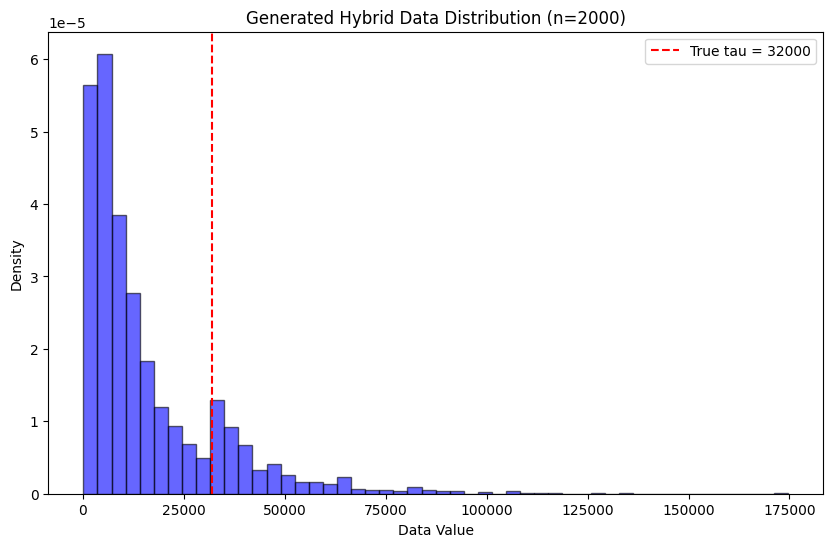


Step 1: Evaluating optimal tau for order 4...

TAU GRID AND VALUES TABLE:
Percentile   Tau Value      
----------------------------------------
    70.0th       17388.60
    71.0th       18140.97
    72.0th       18737.04
    73.0th       19664.36
    74.0th       20632.31
    75.0th       21262.34
    76.0th       22712.27
    77.0th       23628.69
    78.0th       24794.30
    79.0th       25869.86
    80.0th       27360.81
    81.0th       29427.13
    82.0th       32000.00
    83.0th       32432.68
    84.0th       33032.71
    85.0th       33800.27
    86.0th       34484.95
    87.0th       35385.12
    88.0th       36625.93
    89.0th       37598.51
    90.0th       38990.84
Selected tau: 33032.71 (84.0th percentile)
True tau: 32000.00 (82.0th percentile)
Data split: 1680 below tau, 320 above tau

Testing different alpha estimation methods:
------------------------------------------------------------
mle_robust     : α = 3.9279, error = 0.8779 (28.79%)
hill           : α = 2.985

/var/folders/47/1hbxwjcj1g15h5z8zf8tykqc0000gn/T/ipykernel_75831/1905261377.py:679: RuntimeWarning: divide by zero encountered in matmul
  A_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T
/var/folders/47/1hbxwjcj1g15h5z8zf8tykqc0000gn/T/ipykernel_75831/1905261377.py:679: RuntimeWarning: overflow encountered in matmul
  A_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T
/var/folders/47/1hbxwjcj1g15h5z8zf8tykqc0000gn/T/ipykernel_75831/1905261377.py:679: RuntimeWarning: invalid value encountered in matmul
  A_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T


Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
Order 8 - Selected Beta: 3.968502629920499
  Progress: 2/10 (20.0%)
Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
  Progress: 3/10 (30.0%)
Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
  Progress: 4/10 (40.0%)
Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
  Progress: 5/10 (50.0%)
Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
  Progress: 6/10 (60.0%)
Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
  Progress: 7/10 (70.0%)
Selected theta: [np.float64(9.20484705065635), np.float64(1.409112616328262), np.float64(2.4159507727268017)]
  Progress: 8/10 (80.0%)
Selected the

In [ ]:
# Try the safer version first
#results_parallel = application_analysisl_parallel(M=10, orders=[4,8], n_jobs=2)

# Or try the thread-based version for Jupyter compatibility
#results_parallel = application_analysisl_parallel_mp(M=100, orders=[4,8], n_jobs=2)

# For larger jobs after testing
results_parallel = application_analysisl_parallel(M=1000, orders=[4,8,11,20], n_jobs=8)